## Testing Keras with a date difference for the task loading
Started on day Mon, 19 Dec

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import string
import pandas as pd

2022-12-30 11:18:43.623399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset = pd.read_pickle("./data/nc_tasks.pkl")

reviews = dataset["text"].to_numpy()
labels = dataset["label"].to_numpy()

print("Total examples:", reviews.shape[0])

Total examples: 641553


In [3]:
val_split = 5000
test_split = 5000
train_split = 15000

# Separating the negative and positive samples for manual stratification
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]

# Creating training, validation and testing splits
x_val, y_val = (
    tf.concat((x_positives[:val_split], x_negatives[:val_split]), 0),
    tf.concat((y_positives[:val_split], y_negatives[:val_split]), 0),
)
x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
)
x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)

# Remaining pool of samples are stored separately. These are only labeled as and when required
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :],
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :],
)

# Creating TF Datasets for faster prefetching and parallelization
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices(
    (x_pool_negatives, y_pool_negatives)
)
pool_positives = tf.data.Dataset.from_tensor_slices(
    (x_pool_positives, y_pool_positives)
)

print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")


2022-12-30 11:18:57.207613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initial training set size: 30000
Validation set size: 10000
Testing set size: 10000
Unlabeled negative pool: 11384
Unlabeled positive pool: 580169


In [4]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


vectorizer = layers.TextVectorization(
    30000, standardize=custom_standardization, output_sequence_length=150
)
# Adapting the dataset
vectorizer.adapt(
    train_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE).batch(256)
)


def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label


train_dataset = train_dataset.map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)
pool_negatives = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [5]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies, optimizer):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(f"model/active/{optimizer}_loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.savefig(f"model/active/{optimizer}_accuracy")
    plt.show()


In [6]:
def create_model():
    model = keras.models.Sequential(
        [
            layers.Input(shape=(150,)),
            layers.Embedding(input_dim=30000, output_dim=128),
            layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
            layers.GlobalMaxPool1D(),
            layers.Dense(20, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.summary()
    return model


In [7]:
def train_active_learning_models(
    train_dataset,
    pool_negatives,
    pool_positives,
    val_dataset,
    test_dataset,
    optimizer,
    num_iterations=5,
    sampling_size=10000,
):

    # Creating lists for storing metrics
    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    model = create_model()
    # We will monitor the false positives and false negatives predicted by our model
    # These will decide the subsequent sampling ratio for every Active Learning loop
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # Defining checkpoints.
    # The checkpoint callback is reused throughout the training since it only saves the best overall model.
    checkpoint = keras.callbacks.ModelCheckpoint(
        f"model/active/{optimizer}_Model.h5", save_best_only=True, verbose=1
    )
    # Here, patience is set to 4. This can be set higher if desired.
    early_stopping = keras.callbacks.EarlyStopping(patience=4, verbose=1)

    print(f"Starting to train with {len(train_dataset)} samples")
    # Initial fit with a small subset of the training set
    history = model.fit(
        train_dataset.cache().shuffle(20000).batch(256),
        epochs=40,
        validation_data=val_dataset,
        callbacks=[checkpoint, early_stopping],
    )

    # Appending history
    losses, val_losses, accuracies, val_accuracies = append_history(
        losses, val_losses, accuracies, val_accuracies, history
    )

    for _ in range(num_iterations):
        # Getting predictions from previously trained model
        predictions = model.predict(test_dataset)

        # Generating labels from the output probabilities
        rounded = tf.where(tf.greater(predictions, 0.5), 1, 0)

        # Evaluating the number of zeros and ones incorrrectly classified
        _, _, false_negatives, false_positives = model.evaluate(test_dataset, verbose=0)

        print("-" * 100)
        print(
            f"Number of zeros incorrectly classified: {false_negatives}, Number of ones incorrectly classified: {false_positives}"
        )

        # This technique of Active Learning demonstrates ratio based sampling where
        # Number of ones/zeros to sample = Number of ones/zeros incorrectly classified / Total incorrectly classified
        if false_negatives != 0 and false_positives != 0:
            total = false_negatives + false_positives
            sample_ratio_ones, sample_ratio_zeros = (
                false_positives / total,
                false_negatives / total,
            )
        # In the case where all samples are correctly predicted, we can sample both classes equally
        else:
            sample_ratio_ones, sample_ratio_zeros = 0.5, 0.5

        print(
            f"Sample ratio for positives: {sample_ratio_ones}, Sample ratio for negatives:{sample_ratio_zeros}"
        )

        # Sample the required number of ones and zeros
        sampled_dataset = pool_negatives.take(
            int(sample_ratio_zeros * sampling_size)
        ).concatenate(pool_positives.take(int(sample_ratio_ones * sampling_size)))

        # Skip the sampled data points to avoid repetition of sample
        pool_negatives = pool_negatives.skip(int(sample_ratio_zeros * sampling_size))
        pool_positives = pool_positives.skip(int(sample_ratio_ones * sampling_size))

        # Concatenating the train_dataset with the sampled_dataset
        train_dataset = train_dataset.concatenate(sampled_dataset).prefetch(
            tf.data.AUTOTUNE
        )

        print(f"Starting training with {len(train_dataset)} samples")
        print("-" * 100)

        # We recompile the model to reset the optimizer states and retrain the model
        model.compile(
            loss="binary_crossentropy",
            optimizer=optimizer,
            metrics=[
                keras.metrics.BinaryAccuracy(),
                keras.metrics.FalseNegatives(),
                keras.metrics.FalsePositives(),
            ],
        )
        history = model.fit(
            train_dataset.cache().shuffle(20000).batch(256),
            validation_data=val_dataset,
            epochs=40,
            callbacks=[
                checkpoint,
                keras.callbacks.EarlyStopping(patience=4, verbose=1),
            ],
        )

        # Appending the history
        losses, val_losses, accuracies, val_accuracies = append_history(
            losses, val_losses, accuracies, val_accuracies, history
        )

        # Loading the best model from this training loop
        model = keras.models.load_model(f"model/active/{optimizer}_Model.h5")

    # Plotting the overall history and evaluating the final model
    plot_history(losses, val_losses, accuracies, val_accuracies, optimizer)
    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model, model.evaluate(test_dataset, verbose=0, return_dict=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          3840000   
                                                                 
 bidirectional (Bidirectiona  (None, 150, 64)          41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

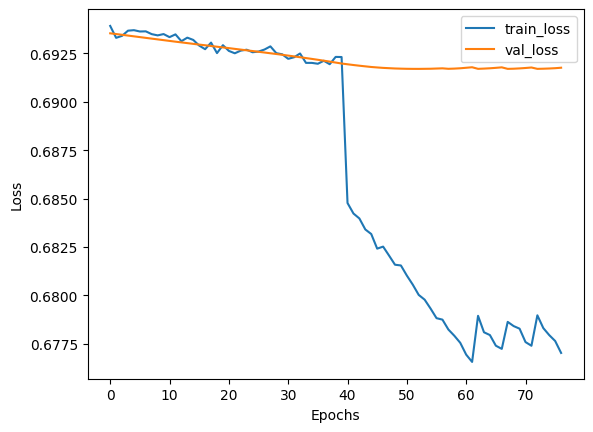

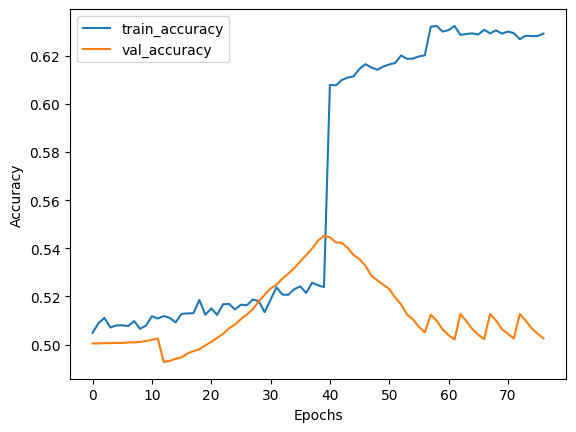

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'loss': 0.6893324851989746, 'binary_accuracy': 0.527999997138977, 'false_negatives_1': 4670.0, 'false_positives_1': 50.0}
----------------------------------------------------------------------------------------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 128)          3840000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 64)          41216     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                     

In [8]:
results_dict = {}
for optimizer in ["Adadelta", "Adagrad", "Adamax", "Adafactor", "Nadam", "Ftri"]:
    model, results = train_active_learning_models(
        train_dataset, pool_negatives, pool_positives, val_dataset, test_dataset, optimizer
    )
    results_dict[optimizer] = results

In [ ]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorizer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

end_to_end_model.save('model/model_keras')